In [2]:
import astropy as astropy
import astropy.units as u
import astroquery
import math
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.io import fits
from astropy.table import Table
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp
from astroquery.vizier import VizierClass
from astropy.coordinates import SkyCoord
from ligo.skymap.io import read_sky_map
from ligo.skymap.postprocess import crossmatch

In [3]:
def distance(x1, y1, x2, y2):
    return ((x2-x1)**2+(y2-y1)**2)**0.5

In [4]:
V = Vizier(catalog = 'V/154/sdss16', columns = ['**'])
V.ROW_LIMIT = 100000000000
V.TIMEOUT = 999999
SDSSDR16 = V.query_constraints(RA_ICRS = '160.5 .. 233', DE_ICRS = '44.5 .. 57.5', rpmag = '<= 19.5', gc = '= 3', rc = '= 3', uc = '= 3', ic = '= 3', zc = '= 3')[0]

In [5]:
zph = []
for source in range(len(SDSSDR16)):
    zph.append(SDSSDR16[source]['zph'] - 2*SDSSDR16[source]['e_zph'])

In [6]:
SDSSsources = []
for source in range(len(zph)):
    if zph[source] <= 0.043:
        SDSSsources.append(SDSSDR16[source])

In [7]:
print(len(SDSSsources))

21994


In [8]:
V = Vizier(catalog = 'I/356/galcand', columns = ["*", 'RadS'])
V.ROW_LIMIT = 100000000000
GaiaSources = V.query_constraints(RA_ICRS = '160.5 .. 233', DE_ICRS = '44.5 .. 57.5')[0]
print(len(GaiaSources))

102702


In [9]:
SDSSDR16RA = []
SDSSDR16DEC = []
GaiaRA = []
GaiaDEC = []
for source in range(len(SDSSsources)):
    SDSSDR16RA.append(SDSSsources[source]['RA_ICRS'])
    SDSSDR16DEC.append(SDSSsources[source]['DE_ICRS'])
for source in range(len(GaiaSources)):
    GaiaRA.append(GaiaSources[source]['RA_ICRS'])
    GaiaDEC.append(GaiaSources[source]['DE_ICRS'])

In [10]:
max_sep = 2.0 * u.arcsec
c = SkyCoord(ra=SDSSDR16RA*u.degree, dec=SDSSDR16DEC*u.degree)
catalog = SkyCoord(ra=GaiaRA*u.degree, dec=GaiaDEC*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
gaia = GaiaSources[idx[sep_constraint]]
print(len(gaia))

11125


In [11]:
SDSSGaia = []
for source in range(len(sep_constraint)):
    if sep_constraint[source] == True:
        SDSSGaia.append(SDSSsources[source])
print(len(SDSSGaia))

11125


In [12]:
GAIA = []
def whatever(gaia):
    for source in range(len(gaia)):
        check = []
        d = distance(gaia[source]['RA_ICRS'], gaia[source]['DE_ICRS'], SDSSGaia[source]['RA_ICRS'], SDSSGaia[source]['DE_ICRS'])
        sigma = (36+gaia[source]['RadS']**2)**0.5
        check.append(math.exp(d**2/(2*sigma**2)))
        prob = max(check)
        for source in range(len(check)):
            if check[source] == prob:
                GAIA.append(gaia[source])
                    

In [13]:
whatever(gaia)

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/3815940814.py:7: RuntimeWarning: divide by zero encountered in true_divide
  check.append(math.exp(d**2/(2*sigma**2)))
/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/3815940814.py:7: UserWarning: Warning: converting a masked element to nan.
  check.append(math.exp(d**2/(2*sigma**2)))


In [14]:
removeGaia = []
for source in range(len(gaia)):
    if gaia[source]['Class'] == 'AGN':
        removeGaia.append(SDSSGaia[source])
    if gaia[source]['Class'] != 'GALAXY':
        if gaia[source]['PGal'] < 0.95:
            removeGaia.append(SDSSGaia[source])
print(len(removeGaia))

494


In [22]:
def DESImatching(SDSS, DESI, list):
    v = Vizier(columns=["*", "+_r"])
    for source in range(len(SDSS)):
        desi = v.query_region(SkyCoord(ra = SDSS[source]['RA_ICRS'] * u.degree, dec = SDSS[source]['DE_ICRS'] * u.degree), radius = 2 * u.arcsec, catalog = 'VII/292/north')
        if len(desi) > 0:
            DESI.append(desi[0][0])
            list.append(SDSS[source])

In [23]:
DESISources = []
SDSSDESI = []
DESImatching(SDSSsources[:4398], DESISources, SDSSDESI)

In [24]:
DESImatching(SDSSsources[4399:8796], DESISources, SDSSDESI)

In [25]:
DESImatching(SDSSsources[8796:13194], DESISources, SDSSDESI)

In [26]:
DESImatching(SDSSsources[13194:17592], DESISources, SDSSDESI)

In [27]:
DESImatching(SDSSsources[17592:], DESISources, SDSSDESI)

In [28]:
print(len(SDSSDESI))
print(len(DESISources))

19522
19522


In [29]:
DESIzph = []
for source in range(len(DESISources)):
    DESIzph.append(DESISources[source]['zphot']-2*DESISources[source]['e_zphot'])

In [30]:
keepDESI = []
for source in range(len(DESISources)):
    if DESIzph[source] <= 0.043 and DESISources[source]['type'] != 'PSF':
        for s in range(len(removeGaia)):
            if SDSSDESI[source]['objID'] == removeGaia[s]['objID']:
                pass
        keepDESI.append(source)


In [31]:
finalSDSS = []
finalDESI = []
for source in range(len(keepDESI)):
    finalSDSS.append(SDSSDESI[keepDESI[source]])
    finalDESI.append(DESISources[keepDESI[source]])
print(len(finalSDSS))

11981


In [32]:
import numpy as np
import mocpy
import astropy.units as u
def check_coverage(ra, dec, moc_file):
    """
    Check if the given array of Right Ascension (RA) and Declination (Dec) coordinates are covered within a Multi-Order Coverage (MOC) file.

    Args:
        ra (array-like): Array of Right Ascension coordinates.
        dec (array-like): Array of Declination coordinates.
        moc_file (str): Path to the MOC file.

    Returns:
        numpy.ndarray: Boolean array indicating whether each coordinate is covered (True) or not (False).
    """
    # Load the MOC file
    moc = mocpy.MOC.from_fits(moc_file)

    # Convert RA and Dec arrays to numpy arrays
    ra = np.array(ra)
    dec = np.array(dec)

    # Check if coordinates are covered by the MOC
    is_covered = moc.contains(ra*u.deg, dec*u.deg)

    return is_covered

In [35]:
result = check_coverage(RA, DEC, '/Users/sarahpelesky/Documents/LOFAR Survey code/LOTSS_DR1_CMAP.fits')

In [34]:
RA = []
DEC = []
for source in range(len(finalSDSS)):
    RA.append(finalSDSS[source]['RA_ICRS'])
    DEC.append(finalSDSS[source]['DE_ICRS'])

In [36]:
print(result)

[False False False ... False False False]


In [37]:
true = []
for i in range(len(result)):
    if result[i] == True:
        true.append(i)
print(len(true))

8805


In [38]:
sdss1 = []
desi = []
for source in range(len(finalSDSS)):
    if source in true:
        sdss1.append(finalSDSS[source])
        desi.append(finalDESI[source])
print(len(sdss1))
print(len(desi))

8805
8805


In [39]:
sdss = []
for source in range(len(sdss1)):
    if sdss1[source]['flags'] <= 200000000000000:
        sdss.append(sdss1[source])
print(len(sdss))

8202


In [129]:
z = []
for source in range(len(sdss)):
    if sdss[source]['zsp'] <= 0.043:
        z.append(sdss[source])
print(len(z))

2434


In [40]:
SDSSsource = []
RA = []
DEC = []
Class = []
rPrad = []
umag = []
rmag = []
gmag = []
imag = []
zmag = []
ZPH = []
ezph = []
zsp = []
flag = []
DESIsource = []
desira = []
desidec = []
desizph = []
desiezph = []

for source in range(len(sdss)):
    SDSSsource.append(sdss[source]['objID'])
    RA.append(sdss[source]['RA_ICRS'])
    DEC.append(sdss[source]['DE_ICRS'])
    Class.append(sdss[source]['class'])
    rPrad.append(sdss[source]['rPrad'])
    umag.append(sdss[source]['uPmag'])
    rmag.append(sdss[source]['rPmag'])
    gmag.append(sdss[source]['gPmag'])
    imag.append(sdss[source]['iPmag'])
    zmag.append(sdss[source]['zPmag'])
    ZPH.append(sdss[source]['zph'])
    ezph.append(sdss[source]['e_zph'])
    DESIsource.append(desi[source]['id'])
    desira.append(desi[source]['RAJ2000'])
    desidec.append(desi[source]['DEJ2000'])
    desizph.append(desi[source]['zphot'])
    desiezph.append(desi[source]['e_zphot'])
    zsp.append(sdss[source]['zsp'])
    flag.append(sdss[source]['flags'])

In [41]:
def makefile():
    data = Table()
    data['SDSS Source'] = np.array(SDSSsource, dtype = np.int64)
    data['RA_ICRS'] = np.array(RA, dtype = np.float64)
    data['DE_ICRS'] = np.array(DEC, dtype = np.float64)
    data['class'] = np.array(Class, dtype = np.float64)
    data['rPrad'] = np.array(rPrad, dtype = np.float64)
    data['umag'] = np.array(umag, dtype = np.float64)
    data['rmag'] = np.array(rmag, dtype = np.float64)
    data['gmag'] = np.array(gmag, dtype = np.float64)
    data['imag'] = np.array(imag, dtype = np.float64)
    data['zmag'] = np.array(zmag, dtype = np.float64)
    data['zph'] = np.array(ZPH, dtype = np.float64)
    data['e_zph'] = np.array(ezph, dtype = np.float64)
    data['DESI Source'] = np.array(DESIsource, dtype = np.int64)
    data['RAJ2000'] = np.array(desira, dtype = np.float64)
    data['DEJ2000'] = np.array(desidec, dtype = np.float64)
    data['zphot'] = np.array(desizph, dtype = np.float64)
    data['e_zphot'] = np.array(desiezph, dtype = np.float64)
    data['flag'] = np.array(flag, dtype = np.int64)
    data['zsp'] = np.array(zsp, dtype = np.float64)
    ascii.write(data, 'SDSSgalaxies.txt', overwrite=True)
    data.write('SDSSgalaxies.fits', format = 'fits',overwrite=True)
    
makefile()

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/2368038253.py:21: UserWarning: Warning: converting a masked element to nan.
  data['zsp'] = np.array(zsp, dtype = np.float64)


In [42]:
file = astropy.io.fits.open('SDSSgalaxies.fits')
SDSS = file[1].data

In [43]:
offset1 = 1.28
A1 = 2.10
B1 = -0.51

In [44]:
offset2 = 1.34
A2 = 2.79
B2 = -0.48

In [261]:
#LoTSS DR1
v = Vizier(columns=["*", "+_r"])
DR1res = 6
DR1 = []
SDSSDR1 = []
DR1flag = []
for source in range(len(SDSS)):
    dr1 = v.query_region(SkyCoord(SDSS[source]['RA_ICRS'] * u.degree, SDSS[source]['DE_ICRS'] * u.degree), radius = max(2*SDSS[source]['rPrad'], DR1res) * u.arcsec, catalog = 'J/A+A/622/A1/lotssdr1')
    if len(dr1) > 0:
        if len(dr1[0]) > 1:
            inEnvelope = []
            for ourc in range(len(dr1[0])):
                ratio = dr1[0][ourc]['Sint']/dr1[0][ourc]['Speak']
                calculated = offset1 + A1 * (dr1[0][ourc]['Speak']/dr1[0][ourc]['rms']) ** B1
                if ratio < calculated:
                    inEnvelope.append(True)
                else:
                    inEnvelope.append(False)
            c = 0
            rem = 0
            for so in range(len(inEnvelope)):
                if inEnvelope[so] == True:
                    c += 1
                    ind = so
                else:
                    dr1[0].remove_row(so-rem)
                    rem += 1
            if c > 1:
                sint = []
                for sou in range(len(dr1[0])):
                    if dr1[0][sou]['Sint'] > 0.8:
                        sint.append(True)
                    else:
                        sint.append(False)
                s = 0
                rem = 0
                for sour in range(len(sint)):
                    if sint[sour] == True:
                        s += 1
                        ind = sour
                    else:
                        dr1[0].remove_row(sour-rem)
                        rem += 1
                if s > 1:
                    Type = []
                    for sourc in range(len(dr1[0])):
                        if dr1[0][sourc]['Type'] == 'S':
                            Type.append(True)
                        else:
                            Type.append(False)
                    t = 0
                    rem = 0
                    for ource in range(len(Type)):
                        if Type[ource] == True:
                            t += 1
                            ind = ource
                        else:
                            dr1[0].remove_row(ource-rem)
                            rem += 1
                    if t > 1:
                        DR1.append(dr1[0][0])
                        SDSSDR1.append(SDSS[source])
                        DR1flag.append(1)
                    else:
                        if t == 1:
                            DR1.append(dr1[0][0])
                            SDSSDR1.append(SDSS[source])
                            DR1flag.append(1)
                else:
                    if s == 1:
                        DR1.append(dr1[0][0])
                        SDSSDR1.append(SDSS[source])
                        DR1flag.append(1)
            else:
                if c == 1:
                    DR1.append(dr1[0][0])
                    SDSSDR1.append(SDSS[source])
                    DR1flag.append(1)
        else:
            DR1.append(dr1[0][0])
            SDSSDR1.append(SDSS[source])
            DR1flag.append(0)

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/756708699.py:13: RuntimeWarning: divide by zero encountered in float_scalars
  ratio = dr1[0][ourc]['Sint']/dr1[0][ourc]['Speak']
/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/756708699.py:14: RuntimeWarning: divide by zero encountered in power
  calculated = offset1 + A1 * (dr1[0][ourc]['Speak']/dr1[0][ourc]['rms']) ** B1


In [354]:
print(len(DR1))

2615


In [48]:
ratio = []
calculated = []
inEnvelope = []
for source in range(len(DR1)):
    ratio.append(DR1[source]['Sint']/DR1[source]['Speak'])
    calculated.append(offset1 + A1 * (DR1[source]['Speak']/DR1[source]['rms']) ** B1)
for source in range(len(ratio)):
    if ratio[source] < calculated[source]:
        inEnvelope.append(True)
    else:
        inEnvelope.append(False)
        
compact1 = []
sdsscompact1 = []
for source in range(len(inEnvelope)):
    if inEnvelope[source] == True:
        compact1.append(DR1[source])
        sdsscompact1.append(SDSSDR1[source])
print(len(compact1))

1110


/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/384291470.py:5: RuntimeWarning: divide by zero encountered in float_scalars
  ratio.append(DR1[source]['Sint']/DR1[source]['Speak'])
/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/384291470.py:6: RuntimeWarning: divide by zero encountered in power
  calculated.append(offset1 + A1 * (DR1[source]['Speak']/DR1[source]['rms']) ** B1)


In [133]:
Compact1 = []
sdssCompact1 = []
for source in range(len(compact1)):
    if compact1[source]['Type'] == 'S':
        Compact1.append(compact1[source])
        sdssCompact1.append(sdsscompact1[source])
print(len(Compact1))

1078


In [141]:
c1 = []
sdssc1 = []
for source in range(len(Compact1)):
    if Compact1[source]['Sint'] > 0.8:
        c1.append(Compact1[source])
        sdssc1.append(sdssCompact1[source])
print(len(c1))

709


In [52]:
#LoTSS DR2
v = Vizier(columns=["*", "+_r"])
DR2res = 6
DR2 = []
SDSSDR2 = []
DR2flag = []
for source in range(len(SDSS)):
    dr2 = v.query_region(SkyCoord(SDSS[source]['RA_ICRS'] * u.degree, SDSS[source]['DE_ICRS'] * u.degree), radius = max(2*SDSS[source]['rPrad'], DR2res) * u.arcsec, catalog = 'J/A+A/659/A1/catalog')
    if len(dr2) > 0:
        if len(dr2[0]) > 1:
            inEnvelope = []
            for ourc in range(len(dr2[0])):
                ratio = dr2[0][ourc]['SpeakTot']/dr2[0][ourc]['Speak']
                calculated = offset2 + A2 * (dr2[0][ourc]['Speak']/dr2[0][ourc]['Islrms']) ** B2
                if ratio < calculated:
                    inEnvelope.append(True)
                else:
                    inEnvelope.append(False)
            c = 0
            rem = 0
            for so in range(len(inEnvelope)):
                if inEnvelope[so] == True:
                    c += 1
                    ind = so
                else:
                    dr2[0].remove_row(so-rem)
                    rem += 1
            if c > 1:
                sint = []
                for sou in range(len(dr2[0])):
                    if dr2[0][sou]['SpeakTot'] > 0.8:
                        sint.append(True)
                    else:
                        sint.append(False)
                s = 0
                rem = 0
                for sour in range(len(sint)):
                    if sint[sour] == True:
                        s += 1
                        ind = sour
                    else:
                        dr2[0].remove_row(sour-rem)
                        rem += 1
                if s > 1:
                    Type = []
                    for sourc in range(len(dr2[0])):
                        if dr2[0][sourc]['SCode'] == 'S':
                            Type.append(True)
                        else:
                            Type.append(False)
                    t = 0
                    rem = 0
                    for ource in range(len(Type)):
                        if Type[ource] == True:
                            t += 1
                            ind = ource
                        else:
                            dr2[0].remove_row(ource-rem)
                            rem += 1
                    if t > 1:
                        DR2.append(dr2[0][0])
                        SDSSDR2.append(SDSS[source])
                        DR2flag.append(1)
                    else:
                        if t == 1:
                            DR2.append(dr2[0][0])
                            SDSSDR2.append(SDSS[source])
                            DR2flag.append(1)
                else:
                    if s == 1:
                        DR2.append(dr2[0][0])
                        SDSSDR2.append(SDSS[source])
                        DR2flag.append(1)
            else:
                if c == 1:
                    DR2.append(dr2[0][0])
                    SDSSDR2.append(SDSS[source])
                    DR2flag.append(1)
        else:
            DR2.append(dr2[0][0])
            SDSSDR2.append(SDSS[source])
            DR2flag.append(0)

In [355]:
print(len(DR2))

3214


In [139]:
print(len(DR2))

3214


In [53]:
ratio2 = []
calculated2 = []
inEnvelope2 = []
for source in range(len(DR2)):
    ratio2.append(DR2[source]['SpeakTot']/DR2[source]['Speak'])
    calculated2.append(offset2 + A2 * (DR2[source]['Speak']/DR2[source]['Islrms']) ** B2)
for source in range(len(ratio2)):
    if ratio2[source] < calculated2[source]:
        inEnvelope2.append(True)
    else:
        inEnvelope2.append(False)
        
compact2 = []
sdsscompact2 = []
for source in range(len(inEnvelope2)):
    if inEnvelope2[source] == True:
        compact2.append(DR2[source])
        sdsscompact2.append(SDSSDR2[source])
print(len(compact2))

1296


In [137]:
Compact2 = []
sdssCompact2 = []
for source in range(len(compact2)):
    if compact2[source]['SCode'] == 'S':
        Compact2.append(compact2[source])
        sdssCompact2.append(sdsscompact2[source])
print(len(Compact2))

1268


In [155]:
c2 = []
sdssc2 = []
for source in range(len(Compact2)):
    if Compact2[source]['SpeakTot'] > 1.23:
        c2.append(Compact2[source])
        sdssc2.append(sdssCompact2[source])
print(len(c2))

485


In [156]:
DR1RA = []
DR1DEC = []
for source in range(len(c1)):
    DR1RA.append(c1[source]['RAJ2000'])
    DR1DEC.append(c1[source]['DEJ2000'])
DR2RA = []
DR2DEC = []
for source in range(len(c2)):
    DR2RA.append(c2[source]['RAJ2000'])
    DR2DEC.append(c2[source]['DEJ2000'])

In [157]:
max_sep = 2.0 * u.arcsec
c = SkyCoord(ra=DR1RA*u.degree, dec=DR1DEC*u.degree)
catalog = SkyCoord(ra=DR2RA*u.degree, dec=DR2DEC*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]
print(len(catalog_matches))

408


In [158]:
DR2matches = []
DR1matches = []
SDSSDR1matches = []
SDSSDR2matches = []
for source in range(len(sep_constraint)):
    if sep_constraint[source] == True:
        DR1matches.append(c1[source])
        SDSSDR1matches.append(sdssc1[source])
for source in range(len(idx[sep_constraint])):
    SDSSDR2matches.append(sdssc2[idx[sep_constraint][source]])
    DR2matches.append(c2[idx[sep_constraint][source]])

In [159]:
zspSDSSDR1 = []
zspDR1 = []
zspSDSSDR2 = []
zspDR2 = []
for source in range(len(DR1matches)):
    if SDSSDR1matches[source]['zsp'] <= 0.043:
        zspSDSSDR1.append(SDSSDR1matches[source])
        zspDR1.append(DR1matches[source])
    if SDSSDR2matches[source]['zsp'] <= 0.043:
        zspSDSSDR2.append(SDSSDR2matches[source])
        zspDR2.append(DR2matches[source])
print(len(zspSDSSDR1))

136


In [153]:
#don't change
diff = []
for source in range(len(zspDR1)):
    diff.append(zspDR2[source]['SpeakTot']-zspDR1[source]['Sint'])

0.4269999880790709

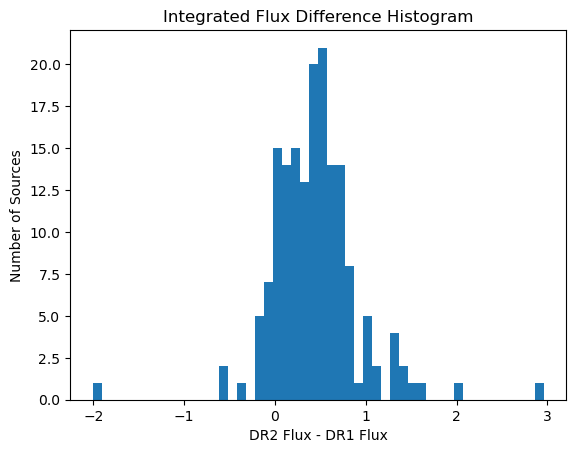

In [154]:
plt.hist(diff, bins=50)
plt.xlabel('DR2 Flux - DR1 Flux')
plt.ylabel('Number of Sources')
plt.title('Integrated Flux Difference Histogram')
np.median(diff)

In [115]:
 def galaxy_association_plot():
        fig, ax = plt.subplots(figsize=(8, 10))
        img = plt.imread("WISE_color (2).png")
        ax.imshow(img, extent=[-1, 7, -0.5, 4], aspect="auto")
        ax.scatter(W23, W12, color="black",s=5)
        ax.errorbar(
            W23,
            W12,
            xerr=W23_err,
            yerr=W12_err,
            capsize=0,
            ls="none",
            color="black",
            elinewidth=1,
        )
        
        ylabel = "[3.4] - [4.6] in mag"
        xlabel = "[4.6] - [12] in mag"
        ax.set_ylabel(ylabel, fontsize=18)
        ax.set_xlabel(xlabel, fontsize=18)
        ax.set_ybound(lower=-0.5, upper=4)
        ax.set_xbound(lower=-1, upper=7)
        ax.tick_params(axis="both", which="both", labelsize=16, length=0)
        plt.show()
        # plt.close()

In [116]:
img = plt.imread("WISE_color (2).png")

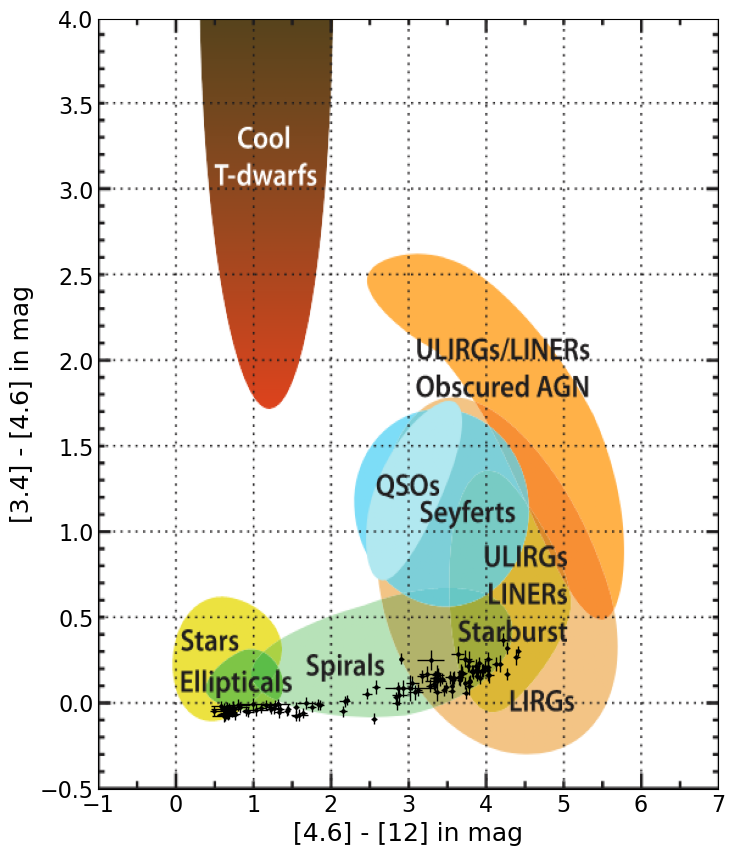

In [127]:
import os.path
WISEfile = astropy.io.ascii.read('WISE Data - Sheet1.csv')
W12 = np.array(WISEfile['W12']).astype(np.float64)
W23 = np.array(WISEfile['W23']).astype(np.float64)
W1_err = np.array(WISEfile['e_W1mag']).astype(np.float64)
W2_err = np.array(WISEfile['e_W2mag']).astype(np.float64)
W3_err = np.array(WISEfile['e_W3mag']).astype(np.float64)
W23_err = []
W12_err = []
for i in range(len(W1_err)):
    W23_err.append(np.sqrt(W2_err[i]**2 + W3_err[i]**2))
    W12_err.append(np.sqrt(W1_err[i]**2 + W2_err[i]**2))
galaxy_association_plot()

In [352]:
finalList = astropy.io.ascii.read('Final Source List - Sheet1.csv')
mass = np.array(finalList['Log(Mass)'][:39]).astype(np.float64)
LOTSSFlux = np.array(finalList['SpeakTot'][:39]).astype(np.float64)
redshift = np.array(finalList['zsp'][:39]).astype(np.float64)
error = np.array(finalList['e_Sint'][:39]).astype(np.float64)
OIII5008 = np.array(finalList['OIII5008'][:39]).astype(np.float64)
OIII5008_err = np.array(finalList['OIII5008_err'][:39]).astype(np.float64)
HBeta = np.array(finalList['HBeta'][:39]).astype(np.float64)
HBeta_err = np.array(finalList['HBeta_err'][:39]).astype(np.float64)
NII6549 = np.array(finalList['NII6549'][:39]).astype(np.float64)
NII6549_err = np.array(finalList['NII6549_err'][:39]).astype(np.float64)
HAlpha = np.array(finalList['HAlpha'][:39]).astype(np.float64)
HAlpha_err = np.array(finalList['HAlpha_err'][:39]).astype(np.float64)
SIIsummed = np.array(finalList['SIIsummed'][:39]).astype(np.float64)
SIIsummed_err = np.array(finalList['SIIsummed_err'][:39]).astype(np.float64)
OI6302 = np.array(finalList['OI6302'][:39]).astype(np.float64)
OI6302_err = np.array(finalList['OI6302_err'][:39]).astype(np.float64)
Wa = np.array(finalList['flux/cont (WHa)'][:39]).astype(np.float64)
cont_err = np.array(finalList['cont_err'][:39]).astype(np.float64)
FIRSTFlux = np.array(finalList['FIRST Flux (mJy)'][:39]).astype(np.float64)

In [318]:
#calculating spectral index
spec = []
spec_err = []
spectral = []
vlasssint = []
firstsint = []
for source in range(len(LOTSSFlux)):
    alpha = np.log(LOTSSFlux[source]/FIRSTFlux[source])/np.log(148/1400)
    spec.append(alpha)
    spectral.append(np.log(LOTSSFlux[source]/0.48)/np.log(148/3000))
for source in range(len(spectral)):
    vlasssint.append((FIRSTFlux[source])/((1400/3000)**spectral[source]))
    firstsint.append(0.48/((3000/1400)**spec[source]))
print(spec)
print(spec_err)
print(spectral)
print(vlasssint)
print(firstsint)

[-0.539650158328008, -0.9663768418059717, -0.6704642946873497, -0.7133597794224689, -0.9800337152451903, -0.5742546654314005, -0.7575920602956944, -0.7285456052924266, -0.5806470214942256, -0.758132479074255, -0.5313370582636462, -0.5690566887425055, -0.509533821744351, -0.9310744019527781, -0.6509706028588336, -0.9068701790192039, -0.8220813018430687, -0.5854496020160789, -0.8814099504744941, -0.8734233441328871, -0.5843868318167854, -0.7088767034721551, -0.6769930397864644, -0.7335202508331441, -0.8231715013965543, -0.5411184368273202, -0.6386625682675263, -0.6267306254166576, -0.7499564718496924, -0.6442782239712602, -0.6023731167663006, -0.5600589467207733, -0.4961146701474947, -0.7723067602691744, -0.5532643901701503, -0.1226951158156324, -0.8439876421781126, -0.46903322614741794, -0.5111047192789113]
[]
[-0.38152354988757275, -0.7001715651038906, -0.4792058990985603, -0.6765335055023175, -0.7103695109646916, -0.7649854104496193, -0.5442664885959247, -0.522576738237627, -0.4121369

In [360]:
from astropy.cosmology import Planck18 as cosmo
SFRcorr = []
SFRerr = []
Flux = []
Flux_err = []
for source in range(len(redshift)):
    D = cosmo.luminosity_distance(z = redshift[source])
    Dis = D.to(u.cm).value
    Ha = HAlpha[source]
    Hb = HBeta[source]
    if Hb == 0 or Ha/Hb > 2.86:
        E = 0
    else:
        E = 1.97 * np.log((Ha/Hb)/2.86)
    ha = Ha * (10**(-17)) * 10 ** (0.4*3.327*E)
    HA = ha * 4 * np.pi * Dis**2
    Fin = (5.5 * 10**(-42)) * HA
    SFRcorr.append(Fin)
    if Ha != 0:
        SFRerr.append(Fin*np.sqrt((HAlpha_err[source]/Ha)**2+0.15**2))
    else:
        SFRerr.append(0.15*Fin)
for source in range(len(LOTSSFlux)):
    d = cosmo.luminosity_distance(z = redshift[source])
    dis = d.to(u.m).value
    sint = LOTSSFlux[source] * 10**(-29)
    fin = sint * 4 * np.pi * dis**2
    err = error[source] * 10**(-29)
    finerr = err * 4 * np.pi * dis**2
    Flux.append(fin)
    Flux_err.append(finerr)
print(SFRcorr)
print(SFRerr)
print(len(SFRcorr))

[0.17686882396776663, 0.2275825078511898, 0.1624759555153194, 0.13755380664151354, 0.24754511547896813, 0.2296169029330092, 0.11793795083462896, 0.19604131536247432, 0.1535937985702791, 0.0716913635674548, 0.019113456826446128, 0.16681396694692116, 0.2505012497402986, 0.20956485080525833, 0.0, 0.07299280334708942, 0.1501216731408278, 0.15888102456138056, 0.13954683564462902, 0.08606510459619215, 0.10282696218984114, 0.24793173088313508, 0.09244250946873706, 0.15496409745577136, 0.1042949186984369, 0.14229621890546187, 0.09100107144336514, 0.18301774242863883, 0.07121499885064916, 0.06917879719051162, 0.16552508316579992, 8.364791310717243e-05, 0.011294585607876644, 0.0005265734962699822, 0.020596401934769273, 0.013217772659728986, 0.013661518789293225, 0.004877012633637942, 0.012306392792472698]
[0.026633844789554027, 0.034196163535912046, 0.02442433391022316, 0.02067097312415308, 0.037195892557587505, 0.03450706993187986, 0.017744148027237682, 0.02947527317115205, 0.023094393494606884

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/3025081485.py:14: RuntimeWarning: divide by zero encountered in log
  E = 1.97 * np.log((Ha/Hb)/2.86)


0.17686882396776663
0.2275825078511898
0.1624759555153194
0.13755380664151354
0.24754511547896813
0.2296169029330092
0.11793795083462896
0.19604131536247432
0.1535937985702791
0.0716913635674548
0.019113456826446128
0.16681396694692116
0.2505012497402986
0.20956485080525833
0.0
0.07299280334708942
0.1501216731408278
0.15888102456138056
0.13954683564462902
0.08606510459619215
0.10282696218984114
0.24793173088313508
0.09244250946873706
0.15496409745577136
0.1042949186984369
0.14229621890546187
0.09100107144336514
0.18301774242863883
0.07121499885064916
0.06917879719051162
0.16552508316579992
8.364791310717243e-05
0.011294585607876644
0.0005265734962699822
0.020596401934769273
0.013217772659728986
0.013661518789293225
0.004877012633637942
0.012306392792472698
nan


/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/3736099186.py:5: RuntimeWarning: divide by zero encountered in log
  logSFRcorr.append(np.log(SFRcorr[source]))


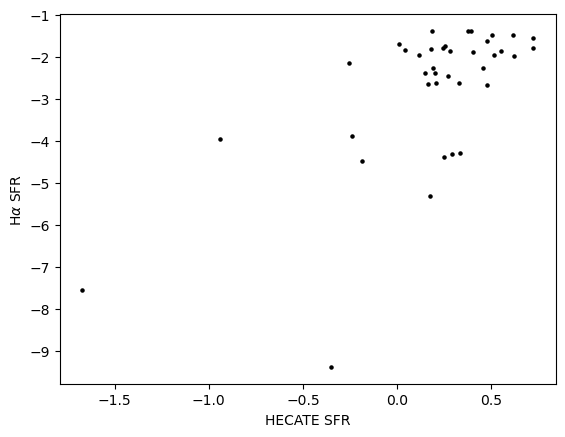

In [371]:
HECATEsfr = np.array(finalList['Log(SFR)'][:39]).astype(np.float64)
logSFRcorr = []
for source in range(len(SFRcorr)):
    print(SFRcorr[source])
    logSFRcorr.append(np.log(SFRcorr[source]))
plt.scatter(HECATEsfr, logSFRcorr, c='black', s=5)
plt.xlabel('HECATE SFR')
plt.ylabel('H' r'$\alpha$' ' SFR')
a, b = np.polyfit(HECATEsfr, logSFRcorr, 1)
print(a)


Text(0, 0.5, 'Number of Sources')

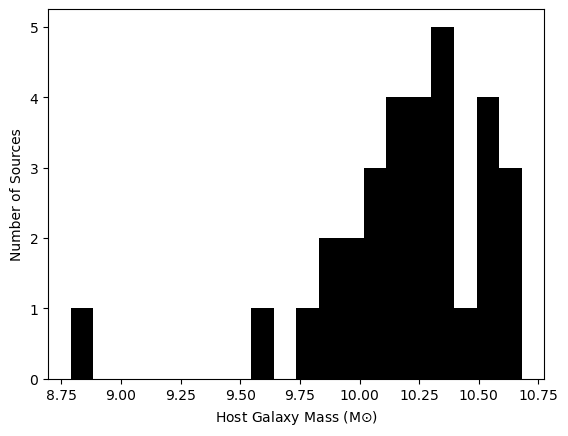

In [347]:
plt.hist(mass[:31], bins=20, color='black')
plt.xlabel('Host Galaxy Mass (M' r'$\odot$' ')')
plt.ylabel('Number of Sources')

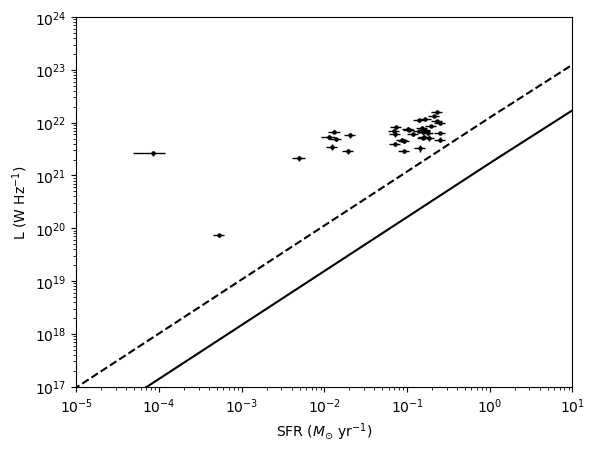

In [375]:
#don't change
def f(x):
    return (1.25*10**22)*x
x = np.linspace(-10, 100, 100)
def g(x):
    return (1.71*10**21)*x
for source in range(len(SFRcorr)):
    plt.scatter(SFRcorr[source], Flux[source], s = 5, c = 'black')
    plt.errorbar(SFRcorr[source], Flux[source],
        xerr=SFRerr[source],
        yerr=Flux_err[source],
        capsize=0,
        ls="none",
        color="black",
        elinewidth=1)
        
plt.plot(x, f(x), linestyle='dashed',color='black')
plt.plot(x, g(x), color='black')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('SFR ($M_{\odot}$ yr$^{-1}$)')
plt.ylim(10e16,10e23)
plt.xlim(10e-6, 10)
plt.ylabel('L (W Hz$^{-1}$)')
plt.show()

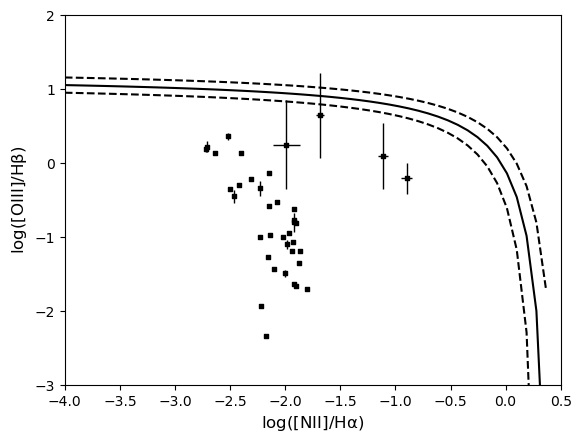

In [348]:
NxPRS = []
NxPRS_err = []
yPRS = []
yPRS_err = []
for source in range(len(HBeta)):
    if HAlpha[source] != 0:
        NxPRS.append(np.log(NII6549[source]/HAlpha[source]))
        NxPRS_err.append((NII6549[source]/HAlpha[source])*np.sqrt((NII6549_err[source]/NII6549[source])**2+(HAlpha_err[source]/HAlpha[source])**2))
        yPRS.append(np.log(OIII5008[source]/HBeta[source]))
        yPRS_err.append((OIII5008[source]/HBeta[source])*np.sqrt((OIII5008_err[source]/OIII5008[source])**2+(HBeta_err[source]/HBeta[source])**2))

from astroML.datasets import fetch_sdss_corrected_spectra
from astroML.datasets.tools.sdss_fits import log_OIII_Hb_NII
plt.scatter(NxPRS,yPRS,c='black',s=5,marker='s')
plt.errorbar(NxPRS, yPRS,
            xerr=NxPRS_err,
            yerr=yPRS_err,
            capsize=0,
            ls="none",
            color="black",
            elinewidth=1)
NII = np.linspace(-4.0, 0.368)
plt.plot(NII, log_OIII_Hb_NII(NII), '-k')
plt.plot(NII, log_OIII_Hb_NII(NII, 0.1), '--k')
plt.plot(NII, log_OIII_Hb_NII(NII, -0.1), '--k')
plt.xlim(-4, 0.5)
plt.ylim(-3, 2)

plt.xlabel(r'$\mathrm{log([NII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.show()

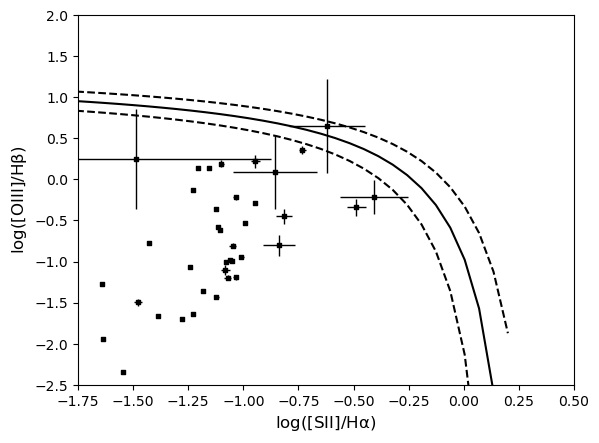

In [349]:
SxPRS = []
SxPRS_err = []
for source in range(len(HBeta)):
    if HAlpha[source] != 0:
        SxPRS.append(np.log(SIIsummed[source]/HAlpha[source]))
        SxPRS_err.append((SIIsummed[source]/HAlpha[source])*np.sqrt((SIIsummed_err[source]/SIIsummed[source])**2+(HAlpha_err[source]/HAlpha[source])**2))

from astroML.datasets.tools.sdss_fits import log_OIII_Hb_SII
plt.scatter(SxPRS,yPRS,c='black',s=5,marker='s')
plt.errorbar(SxPRS, yPRS,
            xerr=SxPRS_err,
            yerr=yPRS_err,
            capsize=0,
            ls="none",
            color="black",
            elinewidth=1)
SII = np.linspace(-3.0, 0.2)
plt.plot(SII, log_OIII_Hb_SII(SII), '-k')
plt.plot(SII, log_OIII_Hb_SII(SII, 0.1), '--k')
plt.plot(SII, log_OIII_Hb_SII(SII, -0.1), '--k')
plt.xlim(-1.75, 0.5)
plt.ylim(-2.5, 2)

plt.xlabel(r'$\mathrm{log([SII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.show()

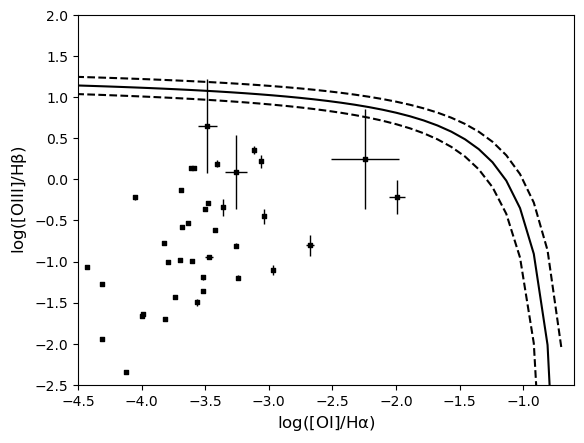

In [350]:
OxPRS = []
OxPRS_err = []
for source in range(len(HBeta)):
    if HAlpha[source] != 0:
        OxPRS.append(np.log(OI6302[source]/HAlpha[source]))
        OxPRS_err.append((OI6302[source]/HAlpha[source])*np.sqrt((OI6302_err[source]/OI6302[source])**2+(HAlpha_err[source]/HAlpha[source])**2))

from astroML.datasets.tools.sdss_fits import log_OIII_Hb_OI
plt.scatter(OxPRS,yPRS,c='black',s=5,marker='s')
plt.errorbar(OxPRS, yPRS,
            xerr=OxPRS_err,
            yerr=yPRS_err,
            capsize=0,
            ls="none",
            color="black",
            elinewidth=1)
OI = np.linspace(-6, -0.7)
plt.plot(OI, log_OIII_Hb_OI(OI), '-k')
plt.plot(OI, log_OIII_Hb_OI(OI, 0.1), '--k')
plt.plot(OI, log_OIII_Hb_OI(OI, -0.1), '--k')
plt.xlim(-4.5, -0.6)
plt.ylim(-2.5, 2)

plt.xlabel(r'$\mathrm{log([OI]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.show()

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/3220756346.py:29: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,max(Walpha)+15)


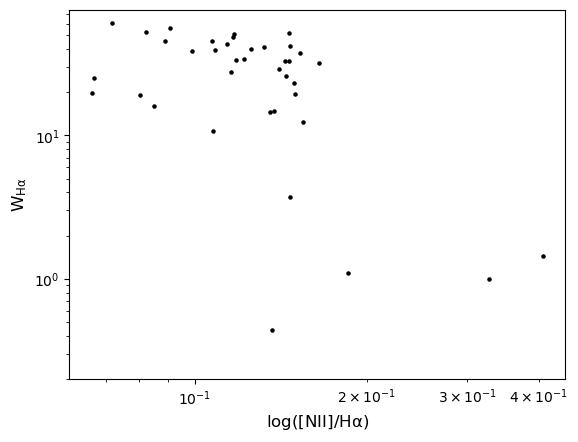

In [351]:
Walpha_err = []
Walpha = []
Nx = []
Nx_err = []
for source in range(len(Wa)):
    if HAlpha[source] != 0 and Wa[source] != 0:
        Walpha.append(Wa[source])
        Walpha_err.append(Wa[source] * np.sqrt((HAlpha_err[source]/HAlpha[source])**2+(cont_err[source]/(HAlpha[source]*Wa[source])**2)))
        Nx.append(NII6549[source]/HAlpha[source])
        Nx_err.append(np.log((NII6549[source]/HAlpha[source])*np.sqrt((NII6549_err[source]/NII6549[source])**2+(HAlpha_err[source]/HAlpha[source])**2)))
    elif HAlpha[source] != 0:
        Walpha.append(Wa[source])
        Walpha_err.append(0)
        Nx.append(NII6549[source]/HAlpha[source])
        Nx_err.append(np.log((NII6549[source]/HAlpha[source])*np.sqrt((NII6549_err[source]/NII6549[source])**2+(HAlpha_err[source]/HAlpha[source])**2)))

plt.scatter(Nx,Walpha,c='black',s=5)
plt.errorbar(Nx_err, Walpha,
            xerr=Nx_err,
            yerr=Walpha_err,
            capsize=0,
            ls="none",
            color="black",
            elinewidth=1)
plt.xlabel(r'$\mathrm{log([NII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{W_{H\alpha}}$', fontsize='large')
plt.yscale('log')
plt.xscale('log')
plt.ylim(0,max(Walpha)+15)
plt.plot((-0.4,-0.4),(0,max(Walpha)+15), 'k--', scaley = True, scalex= True)
plt.plot((-3,0),(3,3), 'k--', scaley = True, scalex= True)


In [303]:
def sSFR_plot():
        fig, ax = plt.subplots(figsize=(8, 10))
        img = plt.imread("SSFR.png")
        ax.imshow(img, aspect="auto", extent=[8,12.5,-15,-8])
        ax.scatter(mass, sSFR, color="pink",s=15,marker='D')
        ylabel = "log(sSFR)"
        xlabel = "log(Mass)"
        ax.set_ylabel(ylabel, fontsize=18)
        ax.set_xlabel(xlabel, fontsize=18)
        ax.tick_params(axis="both", which="both", labelsize=16, length=0)
        plt.show()
        #plt.close()

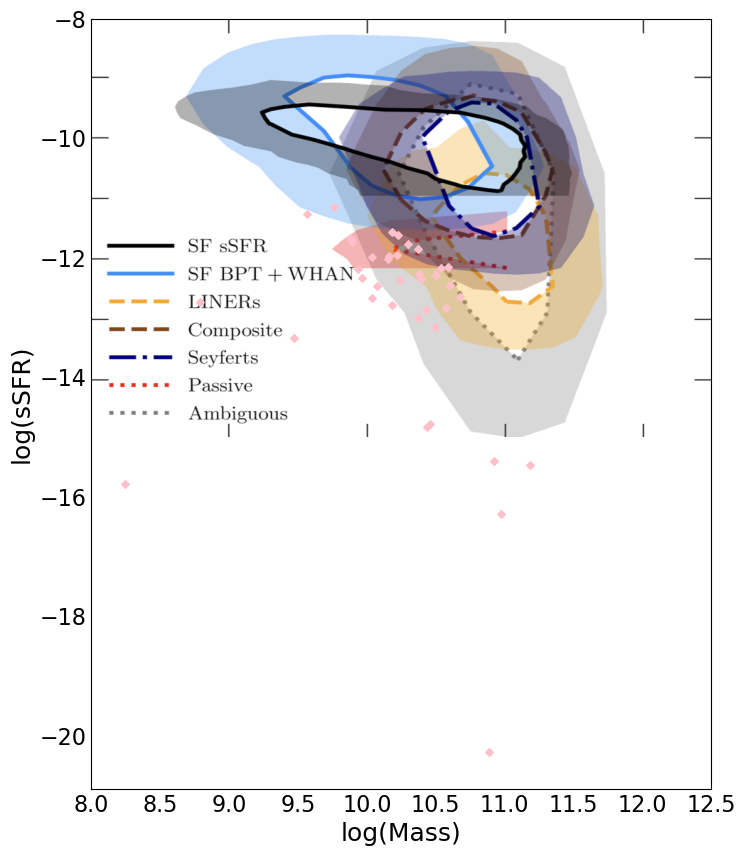

In [369]:
sSFR = []
for source in range(len(SFRcorr)):
    sSFR.append(logSFRcorr[source]-mass[source])
sSFR_plot()

Text(0.5, 0, 'Spectroscopic Redshift')

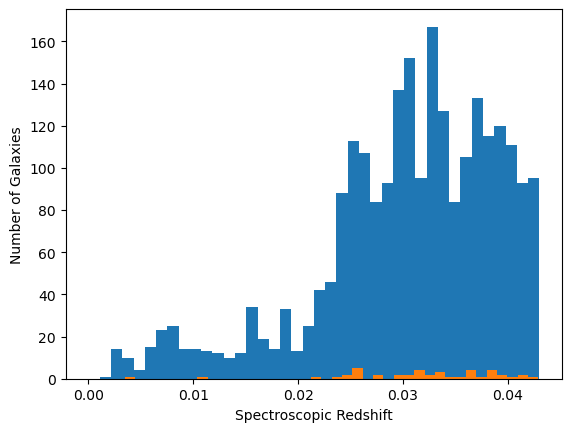

In [306]:
SDSSz = []
for source in range(len(SDSS)):
    if SDSS[source]['zsp'] != 0:
        SDSSz.append(SDSS[source]['zsp'])
plt.hist(SDSSz, range=(0,0.043), bins = 40)
plt.hist(redshift, bins = 40)
plt.ylabel('Number of Galaxies')
plt.xlabel('Spectroscopic Redshift')


In [ ]:
#Chance Assocaition Probability

In [262]:
v = Vizier(columns=["*", "+_r"])
DR1cap = []
for source in range(len(SDSS)):
    dr1 = v.query_region(SkyCoord(SDSS[source]['RA_ICRS'] * u.degree, SDSS[source]['DE_ICRS'] * u.degree), radius = 40 * u.arcsec, catalog = 'J/A+A/622/A1/lotssdr1')
    if len(dr1) > 0:
        DR1cap.append(dr1[0][0])
print(len(DR1cap))

3986


In [264]:
ratio = []
calculated = []
inEnvelope = []
for source in range(len(DR1cap)):
    ratio.append(DR1cap[source]['Sint']/DR1cap[source]['Speak'])
    calculated.append(offset1 + A1 * (DR1cap[source]['Speak']/DR1cap[source]['rms']) ** B1)
for source in range(len(ratio)):
    if ratio[source] < calculated[source]:
        inEnvelope.append(True)
    else:
        inEnvelope.append(False)
        
compact1cap = []
for source in range(len(inEnvelope)):
    if inEnvelope[source] == True:
        compact1cap.append(DR1cap[source])
print(len(compact1cap))

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/4042130290.py:5: RuntimeWarning: divide by zero encountered in float_scalars
  ratio.append(DR1cap[source]['Sint']/DR1cap[source]['Speak'])
/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/4042130290.py:6: RuntimeWarning: divide by zero encountered in power
  calculated.append(offset1 + A1 * (DR1cap[source]['Speak']/DR1cap[source]['rms']) ** B1)


2071


In [265]:
Compact1cap = []
for source in range(len(compact1cap)):
    if compact1cap[source]['Sint'] > 0.8:
        Compact1cap.append(compact1cap[source])
print(len(Compact1cap))

1166


In [266]:
c1cap = []
for source in range(len(Compact1cap)):
    if Compact1cap[source]['Type'] == 'S':
        c1cap.append(Compact1cap[source])
print(len(c1cap))

1106


In [267]:
v = Vizier(columns=["*", "+_r"])
DR2cap = []
for source in range(len(SDSS)):
    dr2 = v.query_region(SkyCoord(SDSS[source]['RA_ICRS'] * u.degree, SDSS[source]['DE_ICRS'] * u.degree), radius = 40 * u.arcsec, catalog = 'J/A+A/659/A1/catalog')
    if len(dr2) > 0:
        DR2cap.append(dr2[0][0])
print(len(DR2cap))

4863


In [268]:
ratio2 = []
calculated2 = []
inEnvelope2 = []
for source in range(len(DR2cap)):
    ratio2.append(DR2cap[source]['SpeakTot']/DR2cap[source]['Speak'])
    calculated2.append(offset2 + A2 * (DR2cap[source]['Speak']/DR2cap[source]['Islrms']) ** B2)
for source in range(len(ratio2)):
    if ratio2[source] < calculated2[source]:
        inEnvelope2.append(True)
    else:
        inEnvelope2.append(False)
        
compact2cap = []
for source in range(len(inEnvelope2)):
    if inEnvelope2[source] == True:
        compact2cap.append(DR2cap[source])
print(len(compact2cap))

2474


In [272]:
Compact2cap = []
for source in range(len(compact2cap)):
    if compact2cap[source]['SpeakTot'] > 1.23:
        Compact2cap.append(compact2cap[source])
print(len(Compact2cap))

743


In [273]:
c2cap = []
for source in range(len(Compact2cap)):
    if Compact2cap[source]['SCode'] == 'S':
        c2cap.append(Compact2cap[source])
print(len(c2cap))

692


In [274]:
off1 = []
off2 = []
for source in range(len(c1cap)):
    off1.append(c1cap[source]['_r'])
for source in range(len(c2cap)):
    off2.append(c2cap[source]['_r'])

0.22165714028534136


Text(0, 0.5, 'Number of Sources')

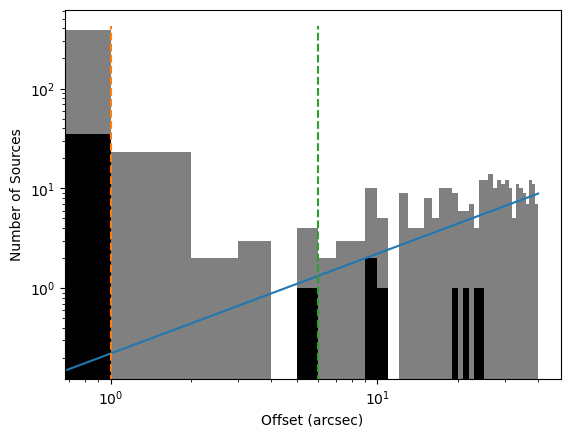

In [315]:
prsoffset = np.array(finalList['Offset'][:43]).astype(np.float64)
plt.hist(off2,bins=40,color='grey',histtype='barstacked',stacked=True,range=(0,40))
plt.hist(prsoffset,histtype='barstacked',stacked=True,bins=40, range=(0,40),color='black')
y = np.array([0,   2.,   3.,   3.,  10.,   5.,
          0.,   9.,   4.,   4.,   8.,   5.,  10.,  10.,   9.,   6.,   6.,
          7.,   4.,  12.,  12.,  14.,  10.,  12.,  11.,  12.,  10.,   5.,
         11.,  10.,   9.,   7.,  12.,  11.,   7.])
x = np.array([0,   7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40.])
a,b = np.polyfit(x,y,1)
print(a) 
z = np.linspace(0,40)
plt.plot(z, a*z)
plt.plot((1,1),(0,420), '--', scaley = False)
plt.plot((6,6),(0,420), '--', scaley = False)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Offset (arcsec)')
plt.ylabel('Number of Sources')

In [288]:
#calculating chance association
chance2 = a * (1)
print(chance2)
chance6 = a * (1+2+3+4+5+6)
print(chance6)

0.22165714028534136
4.654799945992169


In [289]:
V = Vizier(catalog = 'J/A+A/622/A1/lotssdr1',columns = ['**'])
V.ROW_LIMIT = 10000000000
d1 = V.query_constraints(RAJ2000 = '160.5 .. 233', DEJ2000 = '44.5 .. 57.5')

In [290]:
V = Vizier(catalog = 'J/A+A/659/A1/catalog',columns = ['**'])
V.ROW_LIMIT = 10000000000
d2 = V.query_constraints(RAJ2000 = '160.5 .. 233', DEJ2000 = '44.5 .. 57.5')

In [300]:
ratio = []
calculated = []
inEnvelope = []
ccc1 = []
ccc1RA = []
ccc1DEC = []
for source in range(len(d1[0])):
    ratio.append(d1[0][source]['Sint']/d1[0][source]['Speak'])
    calculated.append(offset1 + A1 * (d1[0][source]['Sint']/d1[0][source]['rms']) ** B1)
for source in range(len(ratio)):
    if ratio[source] < calculated[source]:
        if d1[0][source]['Sint'] > 0.8:
            if d1[0][source]['Type'] == 'S':
                ccc1.append(d1[0][source])
                ccc1RA.append(d1[0][source]['RAJ2000'])
                ccc1DEC.append(d1[0][source]['DEJ2000'])

ratio = []
calculated = []
inEnvelope = []
ccc2 = []
ccc2RA = []
ccc2DEC = []
for source in range(len(d2[0])):
    ratio.append(d2[0][source]['SpeakTot']/d2[0][source]['Speak'])
    calculated.append(offset2 + A2 * (d2[0][source]['SpeakTot']/d2[0][source]['Islrms']) ** B2)
for source in range(len(ratio)):
    if ratio[source] < calculated[source]:
        if d2[0][source]['SpeakTot'] > 1.23:
            if d2[0][source]['SCode'] == 'S':
                ccc2.append(d2[0][source])
                ccc2RA.append(d2[0][source]['RAJ2000'])
                ccc2DEC.append(d2[0][source]['DEJ2000'])

print(len(ccc1))
print(len(ccc2))

/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/2277556603.py:8: RuntimeWarning: divide by zero encountered in float_scalars
  ratio.append(d1[0][source]['Sint']/d1[0][source]['Speak'])
/var/folders/97/01qdf1t973j6kp9db4ql0q100000gn/T/ipykernel_27701/2277556603.py:9: RuntimeWarning: divide by zero encountered in power
  calculated.append(offset1 + A1 * (d1[0][source]['Sint']/d1[0][source]['rms']) ** B1)


102652
90054


In [301]:
max_sep = 2.0 * u.arcsec
c = SkyCoord(ra=ccc1RA*u.degree, dec=ccc1DEC*u.degree)
catalog = SkyCoord(ra=ccc2RA*u.degree, dec=ccc2DEC*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
dr1_matches = c[sep_constraint]
dr2_matches = catalog[idx[sep_constraint]]
print(len(dr1_matches))

58352


In [302]:
#calculating chance association
pcc2 = len(dr1_matches) * np.pi * (3282/424) * len(SDSS) * (9.41 * 10 ** -11)
print(pcc2)
pcc6 = len(dr1_matches) * np.pi * (3282/424) * len(SDSS) * (8.47 * 10 ** -10)
print(pcc6)

1.0951856058137777
9.857834305252602
